In [14]:
import numpy as np
from scipy.special import hermitenorm

def multivariate_hermite_polynomial_vectorized(X, indices, precomputed_hermites):
    """
    计算在给定矩阵 X 处关于 x 的第 (i, j, k, l) 分量的多元四次Hermite多项式的值。

    参数:
    X : numpy array
        n*d 矩阵，其中每个行向量是一个 d 维向量。
    indices : tuple of int
        四个整数(i, j, k, l)，每一个都是1到d之间的一个整数。
    precomputed_hermites : dict
        预先计算好的Hermite多项式字典，键是 (索引, 次数)，值是多项式函数。

    返回:
    numpy array
        多元Hermite多项式在 X 处的值，形状为 (n,)。
    """
    unique_indices, counts = np.unique(indices, return_counts=True)

    # 初始化结果为1的向量
    result = np.ones(X.shape[0])
    
    # 计算每个独立索引的Hermite多项式
    for idx, count in zip(unique_indices, counts):
        H = precomputed_hermites[(idx, count)]
        result *= H(X[:, idx - 1])
    
    return result

d = 5
n = d**4+1
# X是一个n*d矩阵，每一个行向量是一个d维向量，是标准正态分布
X = np.random.randn(n, d)
#从R^{d^2}中的单位球面上任取一个方向向量u
u = np.random.randn(d*d)
u = u / np.linalg.norm(u)

# 初始化所有可能的索引 (i, j, k, l)
all_indices = [(i, j, k, l) for i in range(1, d + 1) for j in range(1, d + 1) for k in range(1, d + 1) for l in range(1, d + 1)]

# 预计算所有需要的Hermite多项式
precomputed_hermites = {}
max_order = max([4])  # 这里的4是固定的次数，可以根据实际需要调整
for idx in range(1, d + 1):
    for order in range(1, max_order + 1):
        # 使用归一化的Probabistic Hermite多项式
        precomputed_hermites[(idx, order)] = hermitenorm(order)/ np.sqrt(np.math.factorial(order))
# 计算所有Hermite多项式值
hermite_values = np.array([multivariate_hermite_polynomial_vectorized(X, idx, precomputed_hermites) for idx in all_indices]).reshape(d, d, d*d, n)

# 计算点积
dot_products = np.tensordot(hermite_values, u, axes=([2], [0]))

# 计算点积的平方和
sum_of_squares = np.sum(np.square(dot_products))

# 计算所有平方和求和除以n^2
result = np.sqrt(sum_of_squares) / n
print(result)


0.17809044271012578


/var/folders/0g/h0jlhpbd4b36x6nbn9b_46gm0000gn/T/ipykernel_66012/1767866484.py:49: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  precomputed_hermites[(idx, order)] = hermitenorm(order)/ np.sqrt(np.math.factorial(order))


Shape of Z: (626, 625)
First column of Z: [-1.22218979 -0.37115275  0.58704863], , Normalized 4 order Hermite polynomial: [-1.22218979 -0.37115275  0.58704863]


/var/folders/0g/h0jlhpbd4b36x6nbn9b_46gm0000gn/T/ipykernel_66012/2589691062.py:16: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  precomputed_hermites[(idx, order)] = hermitenorm(order) / np.sqrt(np.math.factorial(order))
/var/folders/0g/h0jlhpbd4b36x6nbn9b_46gm0000gn/T/ipykernel_66012/2589691062.py:28: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  print(f'First column of Z: {Z[0:3, 0]}, , Normalized 4 order Hermite polynomial: {hermitenorm(4)(X[0:3, 0])/ np.sqrt(np.math.factorial(4))}')


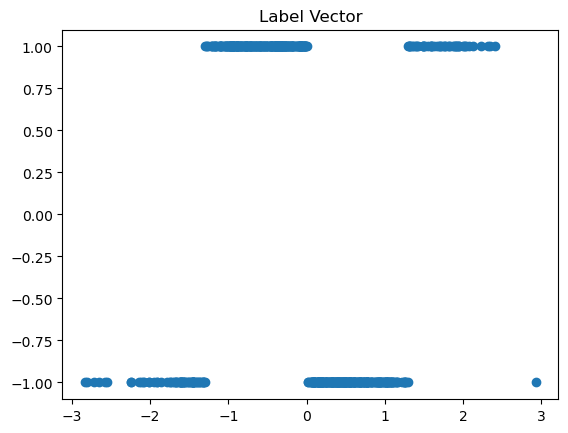

In [27]:
# The realistic oprimization problem part
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.special import hermitenorm

d = 5
n = d**4+1
np.random.seed(0)
X = np.random.randn(n, d)

precomputed_hermites = {}
max_order = max([4])
for idx in range(1, d + 1):
    for order in range(1, max_order + 1):
        precomputed_hermites[(idx, order)] = hermitenorm(order) / np.sqrt(np.math.factorial(order))

def hermite_feature_vector(X):
    n, d = X.shape
    all_indices = [(i, j, k, l) for i in range(1, d + 1) for j in range(1, d + 1) for k in range(1, d + 1) for l in range(1, d + 1)]
    hermite_values = np.array([multivariate_hermite_polynomial_vectorized(X, idx, precomputed_hermites) for idx in all_indices]).reshape(d*d*d*d,n)
    # return the hermite values transposed
    return hermite_values.T

# Generate features
Z = hermite_feature_vector(X)

# Sanity check
print(f'Shape of Z: {Z.shape}')
print(f'First column of Z: {Z[0:3, 0]}, , Normalized 4 order Hermite polynomial: {hermitenorm(4)(X[0:3, 0])/ np.sqrt(np.math.factorial(4))}')

# First we generate the signals
def signal(X):
    n, d = X.shape
    theta_star = np.zeros(d)
    theta_star[0] = 1
    Y = np.sign(X.dot(theta_star)- hermitenorm(5)(X @ theta_star))
    return Y

# Parameters 
theta_star = np.zeros(d)
theta_star[0] = 1
Y = signal(X)

# Plot
plt.scatter(X[:, 0], Y)
plt.title('Label Vector')
plt.show()

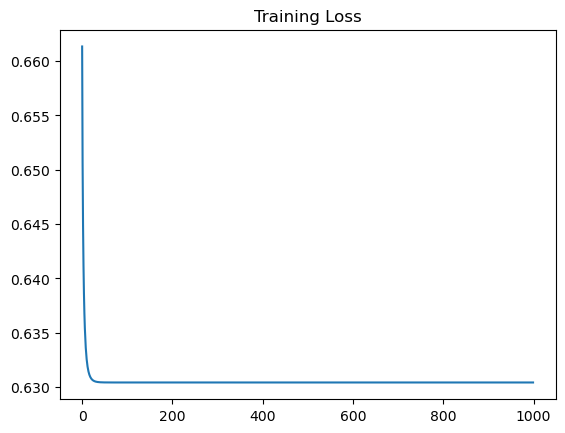

In [28]:
# Function to compute the objective function
def objective(w, Z, Y, lambda_, d):
    n, p = Z.shape
    obj = 0
    for i in range(n):
        obj += np.log(1 + np.exp(-Y[i]*w @ Z[i]))
    obj = obj/n + lambda_ * np.linalg.norm(w)**2
    return obj

# Function to compute the gradient
# Function to compute the gradient
def gradient(w, Z, Y, lambda_, d):
    n, p = Z.shape
    grad = np.zeros(p)
    for i in range(n):
        grad += -Y[i]*Z[i]/(1 + np.exp(Y[i]*w @ Z[i]))
    grad = grad/n + 2*lambda_*w
    return grad

# Function to compute the gradient descent
def gradient_descent(Z, Y, lambda_, step_size, max_iter, d):
    n, p = Z.shape
    w = np.zeros(p)
    obj = np.zeros(max_iter)
    for t in range(max_iter):
        grad = gradient(w, Z, Y, lambda_, d)
        w -= step_size*grad
        obj[t] = objective(w, Z, Y, lambda_, d)
    return w, obj

# Parameters
lambda_ = 0.1
step_size = 0.2
max_iter = 1000
w, obj = gradient_descent(Z, Y, lambda_, step_size, max_iter, d)

# Plot
plt.plot(obj)
plt.title('Training Loss')
plt.show()

In [35]:
# Sanity check
# Function to get weight corresponding to the Hermite polynomial given index (i,j,k,l)
def get_weight(w, i, j, k, l, d):
    return w[(i-1)*d*d*d + (j-1)*d*d + (k-1)*d + l-1]
# Check if w is symmetric up to permutation of indices. Let us randomly pick one multi-index and check if the weights are the same
i, j, k, l = np.random.randint(1, d+1, 4)
print(f'Weight corresponding to ({i},{j},{k},{l}): {get_weight(w, i, j, k, l, d)}')
print(f'Weight corresponding to ({j},{i},{k},{l}): {get_weight(w, j, i, k, l, d)}')

Weight corresponding to (4,2,2,5): -0.012671860273730157
Weight corresponding to (2,4,2,5): -0.012671860273730157
